<h2> Infrastructure </h2>

In [ ]:
# Constant-Gm Current Reference Test Code - Adapted by Shawn Newman

# This code was never tested. Adapting it served as a starting point for other current reference code.

In [ ]:
# Tips:  
  
# VSCode:
#    * Outline button is in the row of buttons right above this. Much easier navigation.
#    * Click on the blue bar to the left of a cell to hide it. Also works on outputs
#
# Structure:
#    * The first code cell should run all the cells that simply define/import things
#    * The headings in the outline with an asterisk are the ones that actually use those functions, 
#      constants, and libraries to do things. You'll manually run those.
#    * Don't click the little "init" buttons in the bottom left of cells, it erases the tag
#
# Misc:
#    * [ctrl+Enter] runs a cell
#    * Select multiple lines of code, then press [ctrl+/] to comment or uncomment all 
#      (I just discovered this a couple months ago and am mad about it)

<h3>* Initialize All Functions and Libraries</h3>

In [20]:
# Turn on File->'Auto Save' if you want to use this. Reads cell data from disk.
# This runs every cell in here with the tag "init". Library imports, function definitions, constants, etc.
# Saves a lot of time

import nbformat # Library for manipulating notebooks

def execute_cells_by_tag(group_tag, quiet=True):
    filepath = globals()['__vsc_ipynb_file__'] # Returns path to this file
    if (quiet==False): print(filepath)
    nb = nbformat.read(open(filepath, 'r', encoding='utf-8'), as_version=4) # Saves this notebook as JSON
    ip = get_ipython()                                                      # Gets the "global InteractiveShell instance"
    if (quiet==False): print(ip)
    for cell_number in range(len(nb.cells)):
        cell=nb.cells[cell_number]
        #print(cell)
        if 'tags' in cell.metadata:
            if group_tag in cell.metadata.tags:
                ip.run_cell(cell.source)
                if (quiet==False): print(f"Ran Cell {cell_number}")

execute_cells_by_tag('init')

Imported Libraries
ICASL is loaded!
Initialized Constants:
Trigger Count = 1201
Initialized Equipment's Establish Connection
Initialized Equipment Functions
Initialized Plotting Default Styling
Initialized Specific Plots
Initialized Full Procedure


<h3> Import Libraries </h3>

In [ ]:
import pyvisa                            # Instrument communication
import time                              # Handle time-related tasks (e.g., delays)
import matplotlib.pyplot as plt          # Plotting graphs and visualizing data
from matplotlib.ticker import LogLocator # Used for ticks in logarithmic plots
import numpy as np                       # Numerical operations, particularly with arrays
import pandas as pd                      # Data manipulation and analysis
import os                                # Interact with the operating system, such as handling file paths
from datetime import date                # Read current date
import importlib.util                    # Used to load python files more dynamically

print("Imported Libraries")

Imported Libraries


In [ ]:
# import ICASL.py
# print("Imported ICASL from this directory")
# ICASL.test()

In [7]:
# Loads ICASL.py from a higher directory
quiet=True
current_dir = "."
target_file = "ICASL.py"
target_name = "ICASL"
while True:
    if not quiet: print(current_dir)
    # Check if ICASL is in the current directory
    ICASL_path = os.path.join(current_dir, target_file)
    if not quiet: print(ICASL_path)
    if os.path.isfile(ICASL_path):
        # Loads ICASL.py
        spec = importlib.util.spec_from_file_location(target_name, ICASL_path)
        ICASL = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(ICASL)
        break
    else:
        # Move one level up
        parent_dir = os.path.join(current_dir, "..")
        if not quiet: print(parent_dir)
        if current_dir == parent_dir:  # Reached the root directory
            raise ValueError("ICASL.py not found")
        else:
            current_dir = parent_dir
ICASL.test()

ICASL is loaded!


<h3> Constants </h3>

In [ ]:
DEVICE_NAME = "Constant-Gm_Current_Reference" # GLOBAL directory
SET_PRECISION = .2  # How close the probe's temperature needs to get to the SET value before soak time begins (in Celsius)
SETTLING_TIME = .25 # How long to wait before setting values and measuring (in seconds)
# Required SETTLING_TIME will vary depending on the circuit. If there's a lot of sweeps, it can make the tests take much longer.
SOAK_TIME = 300     # How long to soak at temperature (in seconds)

# Calcs
def calc_trigger_count(max, min, step):
    trigger_count = int(abs((max-min)/step))+1
    #print(f"Trigger Count = {trigger_count}")  
    return trigger_count   

print("Initialized Constants:")

# Defaults
VDD_DEFAULT = 1.2
IREF_DEFAULT = 1.2
NMOS_DEFAULT = 0 # Why not 1.2V?
CURRENT_RANGE = 1e-4

# Sweeps
VDD_MAX = 1.2
VDD_MIN = 0
VDD_STEP = 0.001
TRIGGER_COUNT_DEFAULT = calc_trigger_count(VDD_MAX, VDD_MIN, VDD_STEP)
print(f"Trigger Count = {TRIGGER_COUNT_DEFAULT}")

VREF_MAX = 1.2
VREF_MIN = 0
VREF_STEP = 0.001

GLOBAL_TEMPS = [125, 100, 75, 50, 25,  0, -25, -50, -75, -100, -125, -150, -175]  

Initialized Constants:
Trigger Count = 1201


<h2> Equipment </h2>

In [3]:
# Enable full pyvisa logging
pyvisa.log_to_screen()

In [ ]:
# Disable full pyvisa logging
import logging
pyvisa.log_to_screen(level=logging.INFO)

<h3>* Find available devices </h3>

In [2]:
rm = pyvisa.ResourceManager()    # Create a ResourceManager object, which manages communication with instruments
rm.list_resources()              # List all available resources (e.g., connected instruments) managed by pyvisa

('ASRL3::INSTR',
 'ASRL4::INSTR',
 'GPIB6::6::INSTR',
 'USB0::0x0957::0x0607::MY45002108::0::INSTR',
 'USB0::0x0957::0x1796::MY57231548::0::INSTR',
 'USB0::0x0957::0x1796::MY57231553::0::INSTR',
 'USB0::0x0957::0x17B6::MY56310504::0::INSTR',
 'USB0::0x0957::0x2C07::MY57890777::0::INSTR',
 'USB0::0x0957::0x5707::MY53802060::0::INSTR',
 'USB0::0x2A8D::0x0101::MY54505624::0::INSTR',
 'USB0::0x2A8D::0x0101::MY57508183::0::INSTR')

In [ ]:
# TODO: ADD POWER SUPPLIES TO TESTING CODE (need physical connections first)

def establish_connection(address, query):
    instrument = rm.open_resource(address)   # Open a connection to the instrument with the address and assign it to SM_VIN
    instrument.read_termination = '\n'       # Set the read termination character to a newline. This tells pyvisa when to consider a message as complete when reading from the instrument.
    instrument.write_termination = '\n'      # Set the write termination character to a newline. This ensures that each command sent to the instrument is properly terminated.
    instrument.baud_rate = 9600              # Set the baud rate for serial communication to 9600. This is the speed at which data is transmitted over the serial connection.
    print(instrument)                        # Print the resource object to display its properties
    if query != "NONE":
        print(instrument.query(query))           # Send the query to the instrument and print its response. This command usually asks the instrument to identify itself (e.g., manufacturer, model number).
    return instrument

print("Initialized Equipment's Establish Connection")

<h3>* Connect Equipment </h3>

In [ ]:
# Corresponding voltages/currents are in the names of equipment
# For a device with multiple channels, list each channel's voltage/current in order
# Everything except the temp chamber needs to be powered on beforehand.

SM_NMOS = establish_connection('GPIB6::20::INSTR', '*IDN?')
SM_IREF = establish_connection('GPIB6::21::INSTR', '*IDN?')
SM_VDD = establish_connection('GPIB6::22::INSTR', '*IDN?')
CHAMBER = establish_connection('GPIB6::6::INSTR', 'STATUS?')

SerialInstrument at ASRL4::INSTR
GPIBInstrument at GPIB6::20::INSTR
KEITHLEY INSTRUMENTS INC.,MODEL 2401,4636506,B02 Jan 20 2021 10:19:49/B01  /W/N
USBInstrument at USB0::10893::257::MY57508183::0::INSTR
Keysight Technologies,34465A,MY57508183,A.02.17-02.40-02.17-00.52-04-01
USBInstrument at USB0::0x2A8D::0x0101::MY54505624::0::INSTR
Keysight Technologies,34465A,MY54505624,A.02.14-02.40-02.14-00.49-02-01
USBInstrument at USB0::2391::22279::MY53802060::0::INSTR
Agilent Technologies,33622A,MY53802060,A.01.11-2.25-03-64-02
GPIBInstrument at GPIB6::6::INSTR
NNNNNNNNNNNNNNNNNN0


VisaIOError: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.

Equipment Info

In [ ]:
# To find IDs

# Waveform Generators: System -> I/O Settings -> USB
# Multimeters:
# SourceMeters:
# Sun Chamber: 'GPIB6::6::INSTR'

# Temperature Chamber Status Code

# Y = power is on
# 2: Y = command error last command
# 3: Y = time out LED is on
# 4: Y = waiting for timeout
# 5: Y = heat output is enabled
# 6: Y = cool output is enabled
# 7: Y = valid set temperature
# 8: Y = deviation limit exceeded
# 9: Y = currently ramping
# 10: Y = chamber temp < lower limit
# 11: Y = chamber temp > upper limit
# 12: Y = waiting at a BKPNT
# 13: Y = in LP run mode
# 14: Y = in LP remote store mode
# 15: Y = in local edit LP mode
# 16: Y = waiting to run LP at TOD
# 17: Y = GPIB bus timeout
# 18: Y = in local keyboard lockout mode
# 19: 0 = system Self Test was OK
# 1 = Battery RAM error found (check default settings)
# 2 = EE RAM error found (check probe calibration)
# 3 = ROM error found (call factory)

<h3> Equipment Functions </h3>

In [ ]:
####### Temperature Chamber #######

def chamber_init():
    CHAMBER.write("ON")                 # Also turns on heat and cool (unless configured otherwise)
    CHAMBER.write("RATE=20")            # Sets the speed at which the chamber will ramp to change temp
    CHAMBER.write("WAIT=FOREV")         # Sets the time that the chamber will wait once the desired temperature is reached before moving to next temp. We don't use this.
    CHAMBER.write("HON")                # Turns heat on (just in case)
    CHAMBER.write("CON")                # Turns cool on (just in case)
    CHAMBER.write("PIDA=3")             # Switches to monitoring user probe when setting temperature (DUT will reach temperature, not the top of the chamber)
    time.sleep(1) 
    #print(CHAMBER.query("RATE?"))
    #print(CHAMBER.query("WAIT?"))

####### SMU #######

# TODO: Figure out when SCPI needs leading colons (never?)
# TODO: Switch to using full names for SCPI commands

def SM_reset(SM):
    SM.write("*CLS")
    # Clear trace buffers and triggers
    SM.write("TRAC:CLE")
    SM.write("TRIG:CLE")

def SM_init(SM):
    # Reset to default settings and clear errors
    # Original code doesn't send "*RST" to SM_VDD, only the other two. Why?
    SM.write("*RST; *CLS")
    # Clear trace buffers and triggers
    SM.write("TRAC:CLE")
    SM.write("TRIG:CLE")

    SM.write("SYST:BEEP:STAT OFF")             # Turn off the beeper on the SMU
    SM.timeout = 150000                        # Set timeout for SMU operations
    SM.write("SYST:AZER ON")                   # Enable auto-zero
    SM.write("SOUR:FUNC VOLT")                 # Set source function to voltage
    SM.write("SENS:FUNC 'CURR'")               # Set measurement function to current
    SM.write(f"SOUR:VOLT:RANG {VDD_MAX}")          
    SM.write(f"SENS:CURR:PROT {CURRENT_RANGE}") # Set current protection (compliance) to 100 µA
    SM.write(f"SENS:CURR:RANG {CURRENT_RANGE}") # Set current range
    SM.write("SENS:CURR:NPLC 1")               # Set NPLC for current measurement to 1
    SM.write("ARM:COUN 1")
    SM.write("ARM:SOUR IMM")
    SM.write("ARM:DIR ACC")
    SM.write("ARM:OUTP NONE")
    SM.write(f"TRIG:COUN {TRIGGER_COUNT_DEFAULT}")      # Set trigger count to match sweep points
    SM.write("TRIG:SOUR TLIN")                 # Immediate trigger source for the master
    SM.write("TRIG:DEL 0")
    SM.write(f":SOUR:DEL {abs(VDD_STEP)}")
    SM.write("TRIG:DIR ACC")
    SM.write("OUTP ON")                        

def SM_trigger_input_sense(SM, trigger_count):
    SM.write(f"TRIG:COUN {trigger_count}")      
    SM.write("TRIG:INP SENS")
    SM.write("TRIG:OUTP SOUR")                 # Set trigger output to Trigger Link
    SM.write("TRIG:OLIN 1")
    SM.write("TRIG:ILIN 2")

def SM_trigger_input_source(SM, trigger_count):
    SM.write(f"TRIG:COUN {trigger_count}")    
    SM.write("TRIG:INP SOUR")
    SM.write("TRIG:OUTP DEL")
    SM.write("TRIG:OLIN 2")
    SM.write("TRIG:ILIN 1")

def SM_set_sweep(SM, start, stop, step):
    if ((stop-start)/step < 0):
        step = step*-1 # Ensure correct step polarity
    SM.write("SOUR:VOLT:MODE SWE")             # Set source mode to sweep
    SM.write(f"SOUR:VOLT:START {start}")        
    SM.write(f"SOUR:VOLT:STOP {stop}")           
    SM.write(f"SOUR:VOLT:STEP {step}")           
    #SM.write(":SOUR:SWE:RANG AUTO")      # Set the sweep range to auto, allowing the SMU to automatically adjust the range.
    SM.write(":SOUR:SWE:SPAC LIN")        # Set the sweep spacing to linear, meaning the voltage will increase linearly between steps.
    #SM.write(":SOUR:SWE:CAB EARL")       # Set the sweep to begin before the trigger event (EARL mode).
    SM.write("OUTP ON")                        # Enable output
    
def SM_set_fixed(SM, level):
    SM.write(":SOUR:VOLT:MODE FIX")
    SM.write(f"SOUR:VOLT:LEV {level}")
    SM.write("OUTP ON")

def SM_off(SM):
    SM.write("SOUR:VOLT:LEV 0")
    SM.write("OUTP:STAT 0")

####### Groupings #######
# Do not affect temperature chamber

def initialize_all():
    SM_init(SM_VDD)
    SM_init(SM_NMOS)
    SM_init(SM_IREF)

def turn_on_all():
    # I'm not sure we should use this. Also why 0 for NMOS and 1.2 for PMOS?
    SM_set_fixed(SM_VDD, VDD_DEFAULT)
    SM_set_fixed(SM_NMOS, NMOS_DEFAULT)
    SM_set_fixed(SM_IREF, IREF_DEFAULT)

def turn_off_all():
    SM_VDD.write(":OUTP OFF")
    SM_IREF.write(":OUTP OFF")
    SM_NMOS.write(":OUTP OFF")

def measure_all():
    SM_VDD.query(":READ?")
    SM_NMOS.query(":READ?")
    SM_IREF.query(":READ?")

print("Initialized Equipment Functions")

SyntaxError: invalid syntax (3521870203.py, line 19)

<h3>* Test Equipment </h3>

In [ ]:
# Test SourceMeters
SM_init(SM_VDD)
print(SM_VDD.query(":CONF?"))
SM_init(SM_NMOS)
print(SM_NMOS.query(":CONF?"))
SM_init(SM_IREF)
print(SM_IREF.query(":CONF?"))

In [ ]:
turn_on_all()

In [ ]:
measure_all()

In [ ]:
turn_off_all()

<h2> Plotting </h2>

<h3> Default Styling </h3>

In [ ]:
# ICASL.start_plot() defines global default plotting parameters. Has a couple styles built in.
# local_start_plot() defines default plotting parameters for this specific file. So if you want to change something about all of these
# plots, you could either add code before the call to ICASL or eliminate the call to ICASL and write your own function entirely.
# These are essentially middle managers
def local_start_plot(title, xlabel, ylabel):
    fig, ax = ICASL.start_plot(title, xlabel, ylabel)
    return fig, ax

def local_finish_plot(fig, ax, save_dir="none", save_file="none", cm=plt.get_cmap('gist_rainbow'), legend=None, legend_style="None", annotations=None, close=True, show=False):
    legend = ax.legend(bbox_to_anchor=(1.02, 1))
    legend_style = "b"
    ICASL.finish_plot(fig, ax, save_dir=save_dir, cm=cm, save_file=save_file, legend=legend, legend_style=legend_style, annotations=annotations, close=close, show=show)

print("Initialized Plotting Default Styling")

Initialized Plotting Default Styling


<h3> Specific Plots </h3>

In [ ]:
################## Initialize and format plots ##################

def VDD_plot_init(title, x_label, y_label):
    fig, ax = local_start_plot(title, x_label, y_label)
    ax.set_xticks(ICASL.arange(VDD_MIN, VDD_MAX, 0.1))
    ax.set_xlim(VDD_MIN, VDD_MAX)
    return fig, ax

# Potential bug - scaling is performed on each temp independently. If different temps
# end up in different Engineering Notation regions, the values would misalign.
def VDD_plot(read_dir, write_dir, plot_temps, direction, current):
    if (direction != "Up" and direction != "Down"): raise ValueError(f"Invalid direction: {direction}. Must be 'Up' or 'Down")
    if (current != "IDD" and current != "IREF"): raise ValueError(f"Invalid current: {current}. Must be 'IDD' or 'IREF")
    
    fig, ax = VDD_plot_init(f"VDD {direction}ward Sweep", "VDD Voltage (V)", f"{current} (mA)")
    for temp in plot_temps:
        df = pd.read_csv(os.path.join(read_dir, f"temp={temp}", f"VDD_Sweep_{direction}.csv"))
        ax.plot(df["VDD"], ICASL.scale(df[current]), label=f"T={temp} °C")
    ax.set_ylabel(f'{current} Current ({ICASL.prefix(df[current])}A)', fontdict={'fontsize': 12})
    local_finish_plot(fig, ax, write_dir, f"VDD_Sweep_{direction}_{current}.png")

def VDD_hysteresis_plot(read_dir, write_dir, plot_temps, current):
    if (current != "IDD" and current != "IREF"): raise ValueError(f"Invalid current: {current}. Must be 'IDD' or 'IREF")
    for temp in plot_temps:
        fig, ax = VDD_plot_init(f"VDD Hysteresis Sweep T={temp} °C", "VDD Voltage (V)", f"{current} (mA)")
        df_up = pd.read_csv(os.path.join(read_dir, f"temp={temp}", f"VDD_Sweep_Up.csv"))
        df_down = pd.read_csv(os.path.join(read_dir, f"temp={temp}", f"VDD_Sweep_Down.csv"))
        ax.plot(df_up["VDD"], ICASL.scale(df_up[current]), label=f"Upwards Sweep")
        ax.plot(df_down["VDD"], ICASL.scale(df_down[current]), label=f"Downwards Sweep")
        ax.set_ylabel(f'{current} Current ({ICASL.prefix(df_up[current])}A)', fontdict={'fontsize': 12})
        local_finish_plot(fig, ax, write_dir, f"VDD_Hysteresis_Sweep_{current}__temp={temp}.png")

def IREF_plot_init():
    fig, ax = local_start_plot("IREF Sweep", "VREF (V)", "IREF (mA)")
    ax.set_xticks(ICASL.arange(VREF_MIN, VREF_MAX, 0.1))
    ax.set_xlim(VREF_MIN, VREF_MAX)
    return fig, ax

def IREF_plot(read_dir, write_dir, plot_temps):
    fig, ax = IREF_plot_init()
    for temp in plot_temps:
        df = pd.read_csv(os.path.join(read_dir, f"temp={temp}", f"IREF_Sweep.csv"))
        ax.plot(df["VREF"], ICASL.scale(df["IREF"]), label=f"T={temp} °C")
        ax.set_ylabel(f'IREF Current ({ICASL.prefix(df["IREF"])}A)', fontdict={'fontsize': 12})
    local_finish_plot(fig, ax, write_dir, "IREF_Sweep.png")

# Runs after each temperature in temperature sweep, all plots except cold start
def plot_all(read_dir, write_dir, plot_temps):
    # Potential bug: if passing a single plot_temp not stored in a list, then when these functions 
    # try to iterate over it, they might fail
    VDD_plot(read_dir, write_dir, plot_temps, "Up", "IDD")
    VDD_plot(read_dir, write_dir, plot_temps, "Up", "IREF")
    VDD_plot(read_dir, write_dir, plot_temps, "Down", "IDD")
    VDD_plot(read_dir, write_dir, plot_temps, "Down", "IREF")
    VDD_hysteresis_plot(read_dir, write_dir, plot_temps, "IDD")
    VDD_hysteresis_plot(read_dir, write_dir, plot_temps, "IREF")
    IREF_plot(read_dir, write_dir, plot_temps)

print("Initialized Specific Plots")

SyntaxError: invalid syntax (795867694.py, line 11)

<h3>* Preview Plot Formatting </h3>

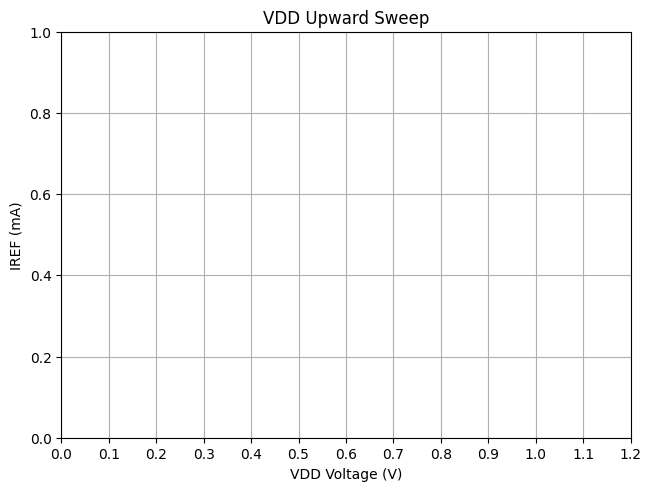

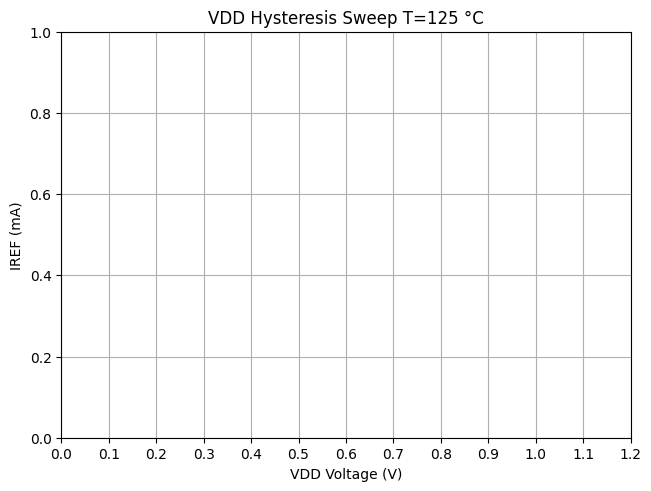

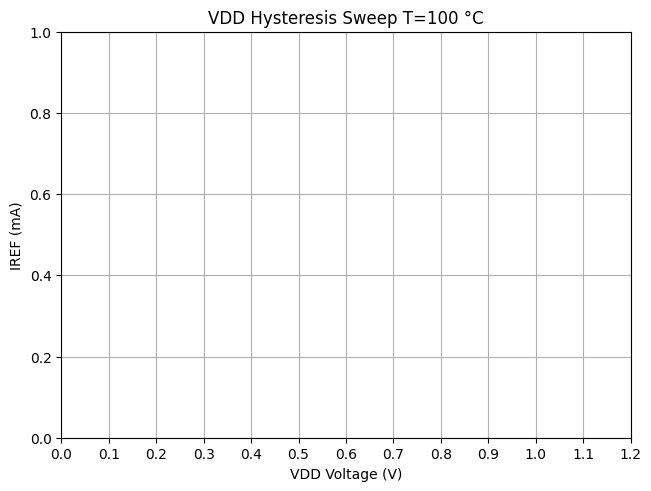

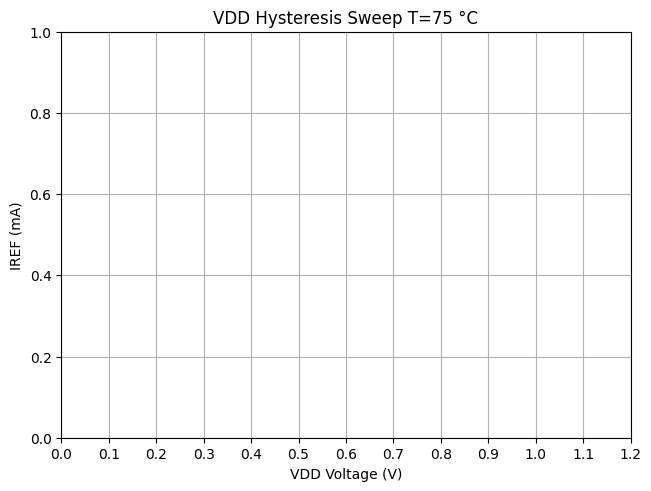

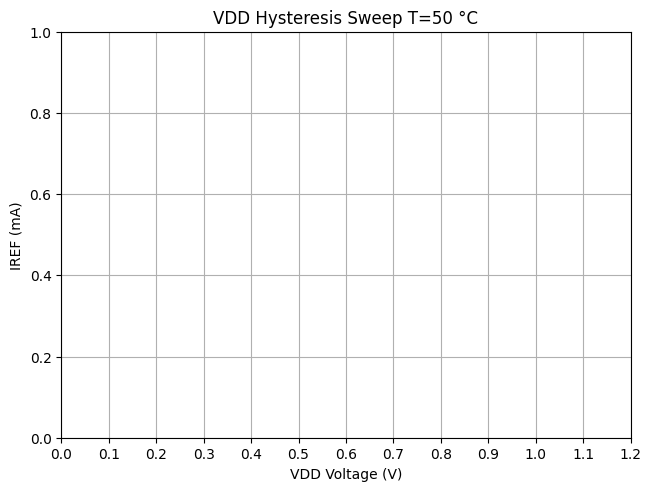

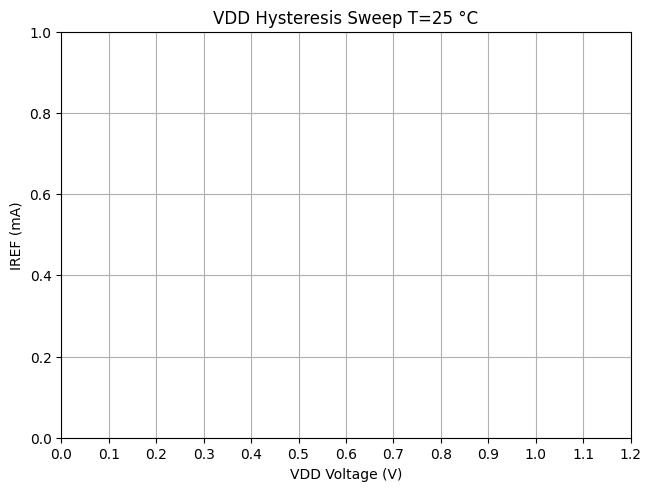

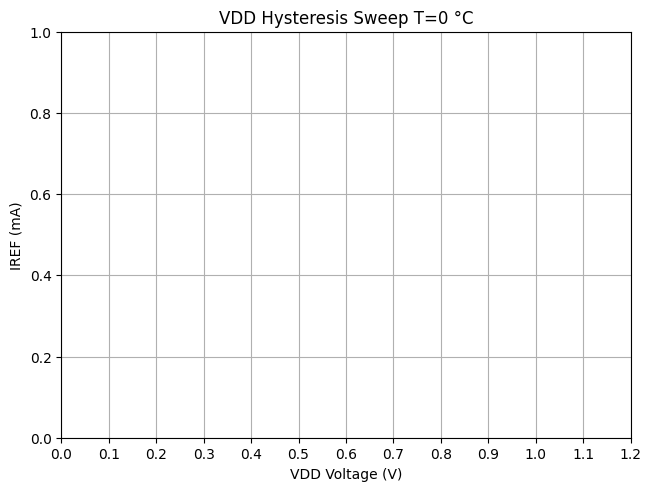

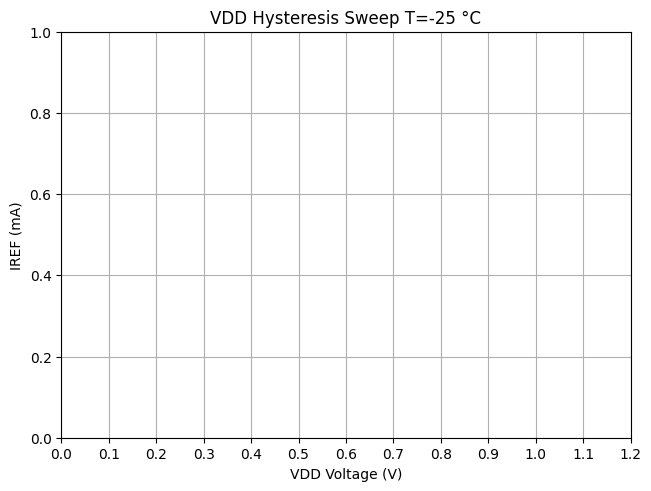

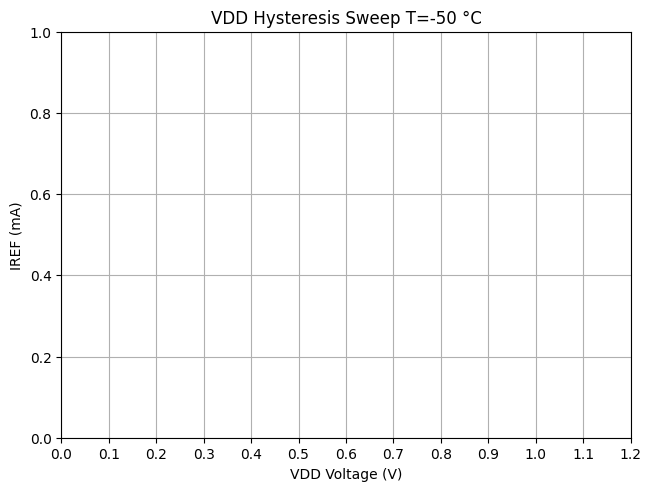

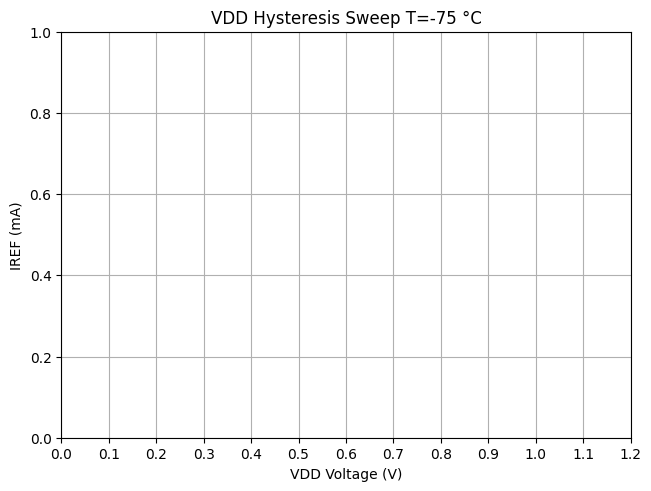

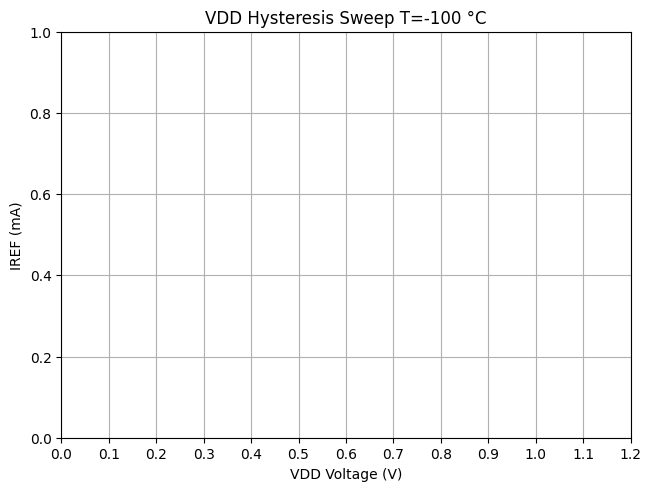

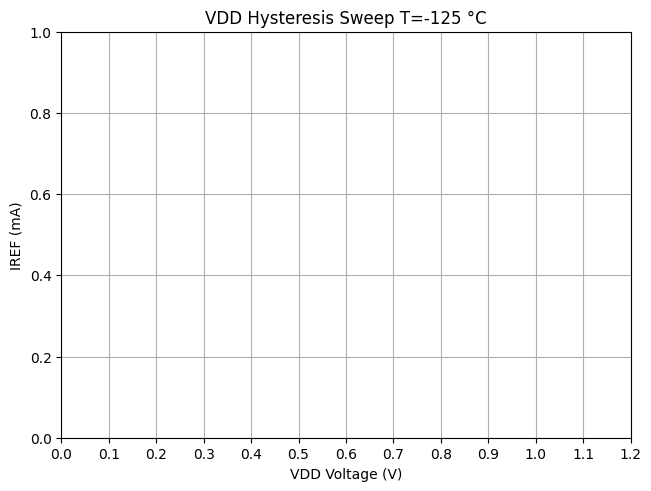

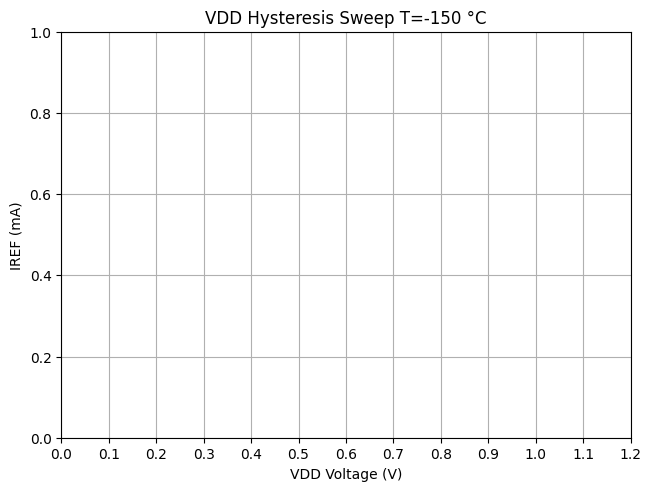

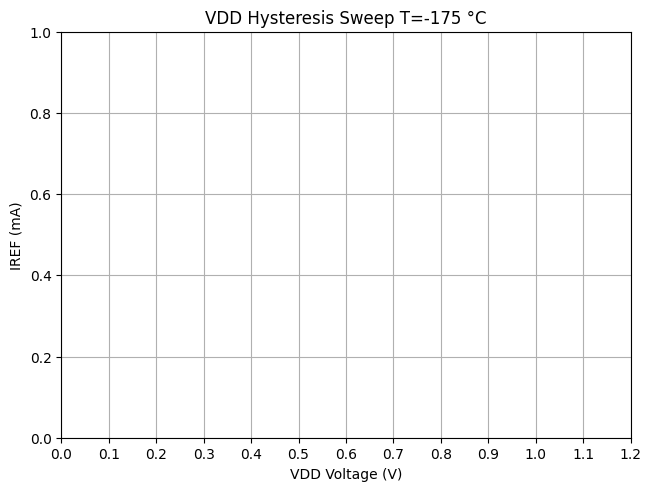

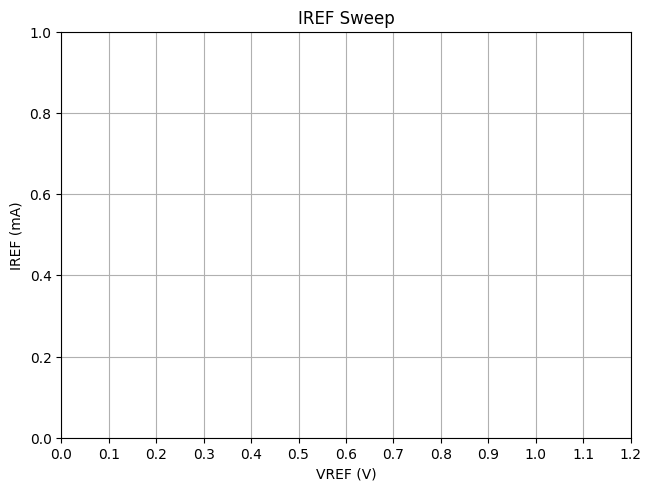

In [17]:
# Use this to print the formatting of all of your plots - not called during tests
# This is why plot initializations are separate
def initialize_all_plots(plot_temps):
    current = "IREF"
    VDD_plot_init(f"VDD Upward Sweep", "VDD Voltage (V)", f"{current} (mA)")
    for temp in plot_temps:
        VDD_plot_init(f"VDD Hysteresis Sweep T={temp} °C", "VDD Voltage (V)", f"{current} (mA)")
        pass # "pass" allows you to comment our the above line without python yelling at you for the loop doing nothing
    IREF_plot_init()
    plt.show()

initialize_all_plots(GLOBAL_TEMPS)

<h3>* Generate Experimental Plots </h3>

In [ ]:
# Manual use - Not called during procedure

#plot_temps = [125, 100, 75, 50, 25,  0, -25, -50, -75, -100, -125, -150, "-175C_Cold_Start"] 
plot_temps = GLOBAL_TEMPS # Manually set
print(plot_temps)
date = "" # Manually set 
run = "" # Manually set
read_dir = os.path.join(f"{DEVICE_NAME}_Results", date, run) 
write_dir = os.path.join(f"{DEVICE_NAME}_Results", date, run, "Plots_Generated_Later") # Make sure this doesn't overwrite anything important
os.makedirs(write_dir, exist_ok=True)

plot_all(read_dir, write_dir, plot_temps)

[125, 100, 75, 50, 25, 0, -25, -50, -75, -100, -125, -150, -175]
[1.7, 1.65, 1.6, 1.55, 1.5, 1.45, 1.4]


<h2> Experimental Procedure </h2>

<h3> Individual Tests </h3>

In [ ]:
# Tests/Sweeps:

def VDD_sweep(save_dir, direction):
    # Equipment intialization/setting
    trigger_count = calc_trigger_count(VDD_MAX, VDD_MIN, -VDD_STEP)
    SM_reset(SM_VDD)
    if direction == "Down": SM_set_sweep(SM_VDD, VDD_MAX, VDD_MIN, -VDD_STEP)
    elif direction == "Up": SM_set_sweep(SM_VDD, VDD_MIN, VDD_MAX, VDD_STEP)
    else: raise ValueError(f"Direction must be 'Up' or 'Down'. Cannot be '{direction}'")
    SM_trigger_input_sense(SM_VDD, trigger_count)
    
    SM_reset(SM_IREF)     
    SM_set_fixed(SM_IREF, 0)
    SM_trigger_input_source(SM_IREF, trigger_count) 

    # For beta multiplier's second device
    SM_reset(SM_NMOS)     
    SM_set_fixed(SM_NMOS, 0)

    time.sleep(.5)
    SM_IREF.write("INIT")                        # Ensure SM_VDD is also ready
    VDD_data = SM_VDD.query("READ?").split(',')     # Initiate the sweep on VDD
    IREF_data = SM_IREF.query("FETC?").split(',')
    # time.sleep(.5) # Why a wait time here?

    # Store data
    df = pd.DataFrame({'VDD':VDD_data[0::5], 'IDD':VDD_data[1::5],
                       'VREF':IREF_data[0::5], 'IREF':IREF_data[1::5]})   # Create a DataFrame
    df.to_csv(os.path.join(save_dir, f'VDD_Sweep_{direction}.csv'), index=False)

def IREF_output_sweep(save_dir):
    # Equipment intialization/setting
    trigger_count = calc_trigger_count(VREF_MAX, VREF_MIN, -VREF_STEP)
    SM_init(SM_VDD)
    SM_set_fixed(SM_VDD, VDD_DEFAULT)
    SM_trigger_input_sense(SM_VDD, trigger_count)
    
    SM_init(SM_IREF)     
    SM_set_sweep(SM_IREF, VREF_MAX, VREF_MIN, -VREF_STEP)
    # In original code, this trigger stuff isn't done for this test
    # Maybe that's why they don't take Q current measurements?
    SM_trigger_input_source(SM_IREF, trigger_count) 

    # For beta multiplier's second device
    SM_off(SM_NMOS)

    time.sleep(.5)
    SM_IREF.write("INIT")                        # Ensure SM_VDD is also ready
    VDD_data = SM_VDD.query("READ?").split(',')     # Initiate the sweep on VDD
    IREF_data = SM_IREF.query("FETC?").split(',')
    # time.sleep(.5) # Why a wait time here?

    # Store inner data
    df = pd.DataFrame({'VREF':IREF_data[0::5], 'IREF':IREF_data[1::5], 
                       'VDD':VDD_data[0::5], 'IDD':VDD_data[1::5]})   # Create a DataFrame
    df.to_csv(os.path.join(save_dir, f'IREF_Sweep.csv'), index=False)

<h3> Full Procedure </h3>

In [ ]:
#####################################################################################################################
################## IMPORTANT: Make sure all CHAMBER commands are contained with an if(USE_CHAMBER): #################
#####################################################################################################################

# USE_CHAMBER = True - turns on the temperature chamber and performs the temperature sweep
# USE_CHAMBER = False - performs a test run without interacting with the chamber.

def run_experiment(USE_CHAMBER, RUN_TYPE, local_temps=GLOBAL_TEMPS):
    # Create file path
    DATE_DIR =  str(date.today())
    i = 1
    RUN_DIR =  os.path.join(f"{DEVICE_NAME}_Results", f"{DATE_DIR}", f"{RUN_TYPE}_{i}")
    while (os.path.isdir(RUN_DIR) == True) and (len(os.listdir(RUN_DIR)) != 0) : # Checks if directory name is taken, updates run number until it is not. Makes sure directory isn't empty.
        i = i+1
        RUN_DIR =  os.path.join(f"{DEVICE_NAME}_Results", f"{DATE_DIR}", f"{RUN_TYPE}_{i}")
    RUN_DIR_ONCE_PLOTTED = RUN_DIR
    RUN_DIR = RUN_DIR + "_No_Plots"        
    os.makedirs(RUN_DIR, exist_ok=True)  # If the directory already exists, it won't raise an error due to exist_ok=True
    
    ################## Initialize Equipment ##################
    
    if (USE_CHAMBER):
        chamber_init()
    initialize_all() 
    turn_on_all()
    
    ################## Temperature Sweep ##################
    
    temps_tested = []        
    for temp in local_temps:
        TEMP_DIR = os.path.join(RUN_DIR, f"temp={temp}") # The temperature of the experiment gets set as the sub directory name
        os.makedirs(TEMP_DIR, exist_ok=True) # Create a directory with the given name. If the directory already exists, it won't raise an error due to exist_ok=True

        if (USE_CHAMBER): 
            user_probe_temp = CHAMBER.query("USER?")
            if (temp < -150 and user_probe_temp < -100):
                CHAMBER.write("RATE=10")     # Slow chamber's rate of change. Hopefully this will result in less LN2 spillage and less overshoot.
                CHAMBER.write("HOFF")        # Stops chamber from heating. We've had issues with it applying a little heat at -175 and rapidly dropping the DUT temp.
            CHAMBER.write(f"SET={temp}")
            while(True):
                time.sleep(.5)
                measure_all() # Updates multimeters periodically during time between tests
                time.sleep(10)
                #print(CHAMBER.query("STATUS?"))
                user_probe_temp = CHAMBER.query("USER?")
                if (temp+SET_PRECISION >= float(user_probe_temp) >= temp-SET_PRECISION):
                    break
            print(CHAMBER.query("STATUS?"))
            time.sleep(SOAK_TIME)  

        # Tests
        VDD_sweep(TEMP_DIR, "Down")
        VDD_sweep(TEMP_DIR, "Up")
        IREF_output_sweep(TEMP_DIR)

        temps_tested.append(temp)
        plot_all(RUN_DIR, TEMP_DIR, temps_tested) # Intermediate plots

        # Changes name of run directory once some plots are in it.
        os.rename(RUN_DIR, RUN_DIR_ONCE_PLOTTED)
        RUN_DIR = RUN_DIR_ONCE_PLOTTED
    
    # Overall plots
    FINAL_PLOTS_DIR = os.path.join(RUN_DIR, "Final_Plots")
    os.makedirs(FINAL_PLOTS_DIR, exist_ok=True)
    plot_all(RUN_DIR, FINAL_PLOTS_DIR, local_temps)

    ##################### Cold Start #####################
    
    turn_off_all()       # Turn off voltages
    if (USE_CHAMBER):
        time.sleep(900)  # Wait 15 minutes for device to cool down
    else:
        time.sleep(5)    # I feel like it's a bad idea to rapidly turn everything off then on, so here's a short wait
    turn_on_all()

    # Cold start data is stored in a subdirectory. This means it is ignored by default but can be
    # parsed identically by simply passing the subdirectory to functions rather than the higher directory
    RUN_DIR_CS = os.path.join(RUN_DIR, "Cold_Start")
    TEMP_DIR_CS = os.path.join(RUN_DIR_CS, "temp=-175")
    os.makedirs(TEMP_DIR_CS, exist_ok=True)
    
    # Tests
    VDD_sweep(TEMP_DIR_CS, "Down")
    VDD_sweep(TEMP_DIR_CS, "Up")
    IREF_output_sweep(TEMP_DIR_CS)
    
    plot_all(RUN_DIR_CS, TEMP_DIR_CS, [-175])

    turn_off_all()
    # Temperature Chamber is NOT off at this point. Close valve, let the pipes empty, then set it back to room temp.

print("Initialized Full Procedure")

Initialized Full Procedure


<h3>* Inputs for Running Experiment</h3>

In [4]:
# To be safe you should run this every time earlier code is changed - it's easy to forget to run a definition after altering it.
execute_cells_by_tag('init') 

Imported Libraries
ICASL is loaded!
Initialized Constants:
VIN: [1.8, 1.775, 1.75, 1.725, 1.7, 1.675, 1.65, 1.625, 1.6, 1.575, 1.55, 1.525, 1.5, 1.475, 1.45, 1.425, 1.4, 1.375, 1.35, 1.325, 1.3, 1.275, 1.25, 1.225, 1.2, 1.175, 1.15, 1.125, 1.1, 1.075, 1.05, 1.025, 1.0]
VREF: [0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3]
VREF Precision: 2
[ 0.1  0.3  0.5  1.   2.   3.   4.   5.   6.   7.   8.   9.  10. ]
0.8
Initialized Equipment's Establish Connection
Initialized Equipment Functions
Initialized Plotting Default Styling
Initialized Specific Plots
Initialized Individual Tests
Initialized Full Procedure


In [ ]:
turn_on_all()

In [ ]:
measure_all()

In [ ]:
# You'll need to run this every time you stop mid-test
turn_off_all()

In [ ]:
# PRACTICE Run, chamber not affected

# Change this if you do a practice run at another temp. For file labeling purposes, doesn't actually set the temp.
practice_temperature = "27"
pr_default = f"Practice_Run_{practice_temperature}°C"
# Can make this one any string you want, really.
pr_name = pr_default        

run_experiment(False, pr_name, local_temps=practice_temperature)

In [ ]:
#
# Buffer so we don't misclick
#

In [ ]:
# ACTUAL Run, chamber sweeps temperature

local_temps = GLOBAL_TEMPS # Can change this to any list of temps. Ex: [0, 27, 50]. Runs in order.

# CHAMBER IS USED # CHAMBER IS USED # CHAMBER IS USED # CHAMBER IS USED # CHAMBER IS USED
run_experiment(True, "Experiment", local_temps=local_temps) # CHAMBER IS USED
# CHAMBER IS USED # CHAMBER IS USED # CHAMBER IS USED# CHAMBER IS USED# CHAMBER IS USED

In [ ]:
# Return to room temperature
# TURN VALVE AND WAIT FIRST
CHAMBER.write("HON")
CHAMBER.write("COFF")
CHAMBER.write("RATE=20")
CHAMBER.write("SET=25")